# 4. Рекоммендательные системы на основе контента. Поиск похожих товаров и пользователей

### В рекомендательных системах существует 2 этапа:
1. Матчинг(поиск кандидатов) - попытка найти релевантные товары с целью уменьшить общий пулл
2. Ранжирование товаров по вероятности для конкретного пользователя

### 1. Общие

ALS (разложение матрицы на 2 методом наименьших квадратов)
- На вход принимает только *позитивные* взаимодействия
- Прогнозирует **не** вероятность, а некоторые числа
- В ALS нельзя добавить внешние фичи
- ALS не учитывает сезонность / зависимость во времени (но это можно частично поправить - см далее)
- Можно использовать для ранжирования (как - см далее + вебинар 5)

### 2. Что на самом деле оптимизирует ALS

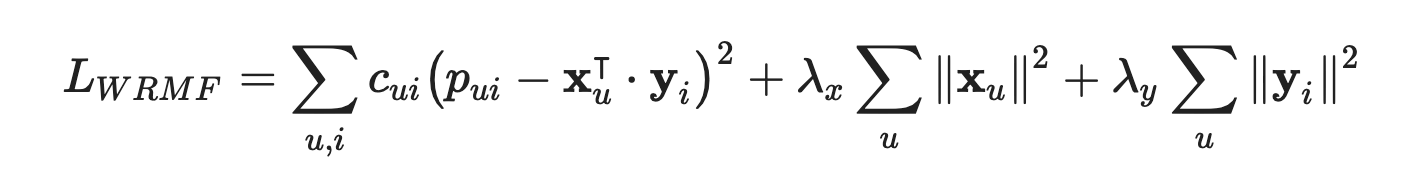

$x_u^T$ - user embeddings  
$y_i$ - item embeddings  
$p_{ui}$ - 0/1. 1 - если в матрице user-item эдемент > 0 (было взаимодействие)  
$c_{ui}$ - Вес ошибки = элемент матрицы user-item  
$\lambda_x$, $\lambda_y$ - коэффициенты регуляризации  

**Что делает ALS**
- Максимизирует скалярное произведение (dot product) между векторами user-item для позитивных взаимодействий, минимизирует для негативных

**Скалярное призведение (dot product) и косинусная схожесть (cosine similarity)**

$$dot(a, b) = a * b$$  
  
$$cos(a, b) = \frac{a * b}{||a||*||b||} = \frac{dot(a, b)}{||a||*||b||}$$

### 3. Как учитывать изменение вкусов потребителей во времени / изменение популярности товара во времени

- Летом юзеры любят мороженое, а зимой - нет
- Многие фильмы популярны во время проката в кино, затем их популярность снижается

*Что делать?*  
Ограничить давность взаимодейстий.  
Давать последним взаимодействиям больший вес:  

$$value_w = \sum_i value_i * \frac{1}{1 + \exp^{ \alpha*t}}$$

Можем по длительности времени уменьшать веса товаров

### 4. Как использовать для ранжирования (Краткое введение. Подробности - на следующем вебинаре)

**Вариант 1.**  
*As is* - ранжировать по output ALS

Мы можем попытаться отранжировать по мере расстояния между векторами, которые нам дает сам ALS

**Вариант 2.**
*Та же модель, другой лосс - BPR*

*Отличие в том, что мы из вероятности взаимодействия пытаемся учитывать(вычитать - пункт 4) лосс среднего по пользователю этого товара*

*Мы понимаем, что из тех товаров, которые у нас есть, мы можем строить матрицы таким образом, чтобы максимизировать вероятность новой покупки*

BPR - Bayesian Personalized Ranking loss
1. Случайная пара user - купленный им item_i = позитивная пара
2. Для того же юзера сэмплируем item_j (не купил или вес в user-item матрице ниже, у item_i из 1.) - негативная пара
3. Прогнозы модели $p_{ui}$, $p_{uj}$ --> $p_{ui} - p_{uj}$
4. loss = $\sigma(p_{ui} - p_{uj})$ - это и есть наша ошибка
5. Обновляем эмбеддинги

In [2]:
from implicit.bpr import BayesianPersonalizedRanking

Синтаксис такой же как у AlternatingLeastSquares. ML модель такая же, лосс - BPR

---

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import ItemItemRecommender  # нужен для одного трюка
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

# Функции из 1-ого вебинара
import os, sys

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items

In [5]:
data = pd.read_csv('retail_train.csv')

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)


test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [6]:
item_features = pd.read_csv('product.csv')
item_features.columns = [col.lower() for col in item_features.columns]
item_features.rename(columns={'product_id': 'item_id'}, inplace=True)

item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [7]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [8]:
n_items_before = data_train['item_id'].nunique()

data_train = prefilter_items(data_train, item_features=item_features, take_n_popular=5000)

n_items_after = data_train['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Ввборка уменьшена с 86865 до 5001 товаров
Decreased # items from 86865 to 5001


Подготавливаем матрицу

In [9]:
user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробоват ьдругие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

user_item_matrix.head(3)

item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Подготавливаем словари

In [10]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [11]:
# Взвешиваем матрицу перед подачей в алгоритм
user_item_matrix = bm25_weight(user_item_matrix.T).T  # Применяется к item-user матрице ! 

In [12]:
# function for recommend
def get_recommendations(user, model, N=5):
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]],  # !!! 
                                    recalculate_user=False)]
    return res

BPR loss лучше работает с данными, в которых пользователи могут выставлять некоторые оценки товару

In [13]:
%%time

model = BayesianPersonalizedRanking(factors=20, 
                                regularization=0.01,
                                learning_rate=0.01,
                                iterations=25, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

  0%|          | 0/25 [00:00<?, ?it/s]

Wall time: 1.63 s


In [14]:
%%time
result['bpr_bm25'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

print("Precision:",result.apply(lambda row: precision_at_k(row['bpr_bm25'], row['actual']), axis=1).mean())

Precision: 0.17130264446620963
Wall time: 17.6 s


Для проверки запустим ALS

In [15]:
%%time

model = AlternatingLeastSquares(factors=20, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

  0%|          | 0/15 [00:00<?, ?it/s]

Wall time: 6.11 s


In [16]:
%%time
result['als_bm25'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

print("Precision:",result.apply(lambda row: precision_at_k(row['als_bm25'], row['actual']), axis=1).mean())


Precision: 0.1308521057786484
Wall time: 18.4 s


Видим, что по метрике байесовский персонализатор в конкретном случае работает лучше

In [17]:
result.head(10)

,user_id,actual,bpr_bm25,als_bm25
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1082185, 1127831, 854852, 878996, 961554]","[960732, 1082212, 999391, 885290, 1075074]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[951590, 826249, 5568378, 883404, 1098066]","[1110244, 8090521, 951590, 885697, 5569230]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[1082185, 854852, 1037863, 878996, 860776]","[1082185, 857006, 863632, 965267, 999250]"
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[1082185, 6534178, 961554, 995242, 883404]","[853643, 857390, 1003188, 1123086, 1052046]"
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[1082185, 826249, 1098066, 961554, 1029743]","[1082185, 840361, 981760, 1068719, 916122]"
5,9,"[864335, 990865, 1029743, 9297474, 10457112, 8...","[1082185, 883404, 981760, 826249, 1098066]","[1082212, 849843, 870428, 1125530, 893018]"
6,13,"[6534178, 1104146, 829197, 840361, 862070, 884...","[1082185, 961554, 826249, 1029743, 1127831]","[970866, 1014948, 5570383, 1031864, 8090532]"
7,14,"[840601, 867293, 933067, 951590, 952408, 96569...","[883404, 918733, 1106523, 1044078, 1033615]","[1008673, 1033615, 985119, 969205, 1127758]"
8,15,"[910439, 1082185, 959076, 1023958, 1082310, 13...","[1082185, 1127831, 878996, 854852, 860776]","[930118, 962274, 878996, 933637, 1028816]"
9,16,"[1062973, 1082185, 13007710]","[1082185, 981760, 1127831, 961554, 840361]","[6410462, 6773204, 480014, 923149, 872702]"


----

# Альтернативные способы предсказаний

### Кейс 1. Продажи товаров собственной торговой марки (СТМ)

У многих ритейлеров есть товары СТМ:

    - Азбука Вкуса - Просто Азбука
    - Ашан - Каждый день
    - ВкусВилл - ВкусВилл
    - ...
    
Как правило, у них маржинальность (~прибыль) > обычные товары.   
Как сделать так, чтобы юзеры переключились на товары СТМ? - *рекоммендации!*

*Нужно заменить те товары, которые пользователь уже покупает, на товары СТМ*

К примеру у нас есть собственные товары, как их корректно впихнуть в рекомендательную систему?

In [18]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [19]:
item_features = item_features[item_features['item_id'].isin(itemid_to_id.keys())]
item_features[item_features['brand'] == 'Private'].item_id.nunique()

1464

In [20]:
own_items = item_features[item_features['brand'] == 'Private'].\
    groupby('department')['item_id'].nunique().\
    sort_values(ascending=False)
own_items

department
GROCERY            1227
MEAT-PCKGD           74
PRODUCE              32
PASTRY               31
DELI                 26
MISC SALES TRAN      20
DRUG GM              14
SEAFOOD-PCKGD        13
KIOSK-GAS            13
MEAT                  8
NUTRITION             5
FLORAL                1
Name: item_id, dtype: int64

In [21]:
categories_with_own_items = own_items.index.tolist()

In [22]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import cm
import pickle

from scipy.spatial.distance import cdist

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns


# Пробуем собрать всю дисперсию в несколько главных компонент
def reduce_dims(df, dims=2, method='pca'):
    
    assert method in ['pca', 'tsne'], 'Неверно указан метод'
    
    if method=='pca':
        pca = PCA(n_components=dims)
        components = pca.fit_transform(df)
    elif method == 'tsne':
        tsne = TSNE(n_components=dims, learning_rate=250, random_state=42, n_iter=300, n_iter_without_progress=20)
        components = tsne.fit_transform(df)
    else:
        print('Error')
        
    colnames = ['component_' + str(i) for i in range(1, dims+1)]
    return pd.DataFrame(data = components, columns = colnames) 

# Отобразим данные
def display_components_in_2D_space(components_df, labels='category', marker='D'):
    
    groups = components_df.groupby(labels)

    # Plot
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    for name, group in groups:
        ax.plot(group.component_1, group.component_2, 
                marker='o', ms=6,
                linestyle='',
                alpha=0.7,
                label=name)
    ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))

    plt.xlabel('component_1')
    plt.ylabel('component_2') 
    plt.show()

In [23]:
model.item_factors.shape

(5001, 20)

In [24]:
category = []

for idx in range(model.item_factors.shape[0]):

    try:
        cat = item_features.loc[item_features['item_id'] == id_to_itemid[idx], 'department'].values[0]
        category.append(cat)
    except:
        category.append('UNKNOWN')

Попробуем отрисовать наши данные

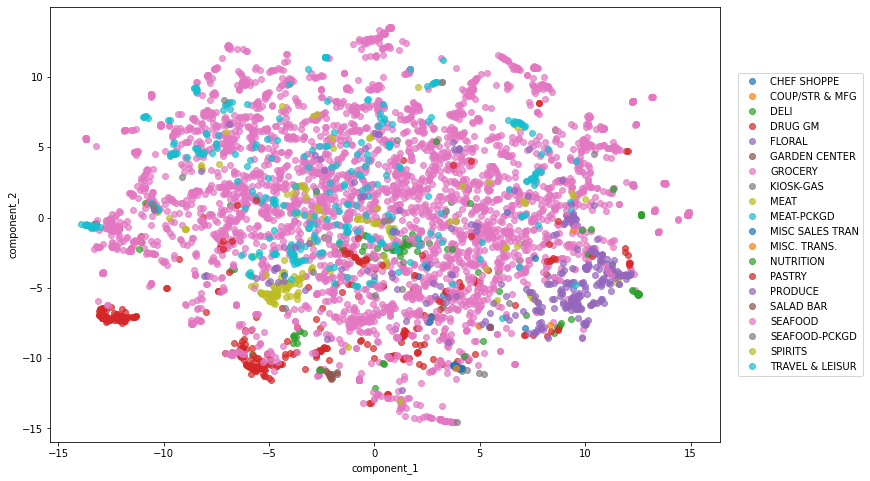

Wall time: 11.2 s


In [25]:
%%time
item_emb_tsne = reduce_dims(model.item_factors, dims=2, method='tsne')
item_emb_tsne['category'] = category  # Добавляем категорию
item_emb_tsne['item_id'] = list(itemid_to_id.keys())
item_emb_tsne = item_emb_tsne[item_emb_tsne['category'] != 'UNKNOWN']

display_components_in_2D_space(item_emb_tsne, labels='category')

Видим огромную кучу товаров категории GROCERY, уберем ее

In [27]:
item_emb_tsne_reduced = item_emb_tsne[item_emb_tsne['category'] != 'GROCERY']

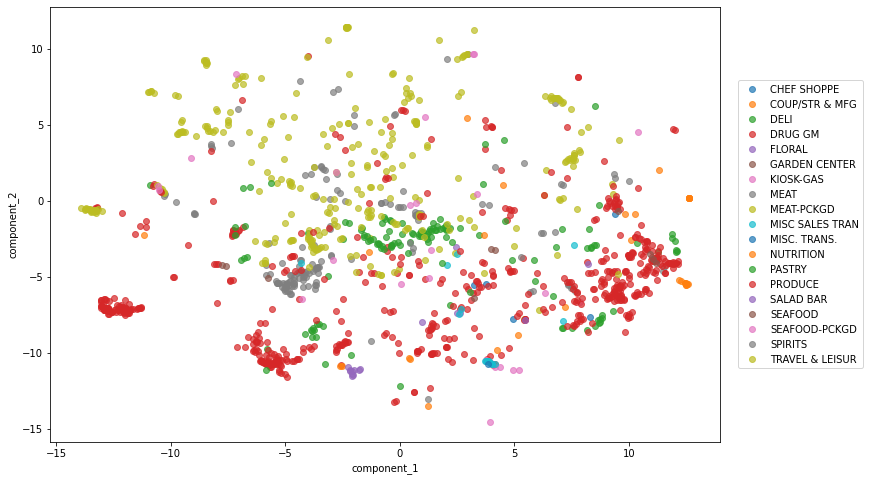

In [28]:
display_components_in_2D_space(item_emb_tsne_reduced, labels='category')

Уже получше 

Нарисуем все товары в категориях, где есть СТМ

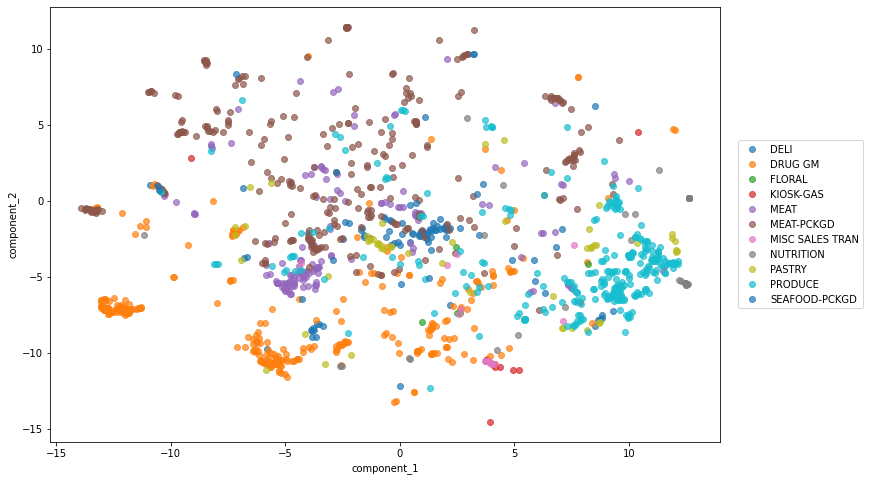

In [29]:
display_components_in_2D_space(item_emb_tsne_reduced[item_emb_tsne_reduced['category'].isin(categories_with_own_items)], 
                               labels='category')

Можем различить какие-то группы товаров, значит возможно получится сделать какие-то заменители

Можно попробовать считать похожие товары для наших товаров, которые не являются СТМ, среди СТМ

In [30]:
similar_items = model.similar_items(itemid_to_id[1004906], N=50)
similar_items = [id_to_itemid[sim[0]] for sim in similar_items]
similar_items.append(1004906)

In [31]:
item_emb_tsne[item_emb_tsne['item_id'] == 1004906]

,component_1,component_2,category,item_id
2430,-4.292484,-2.08348,PRODUCE,1004906


Отрисуем только те товары, которые мы нашли

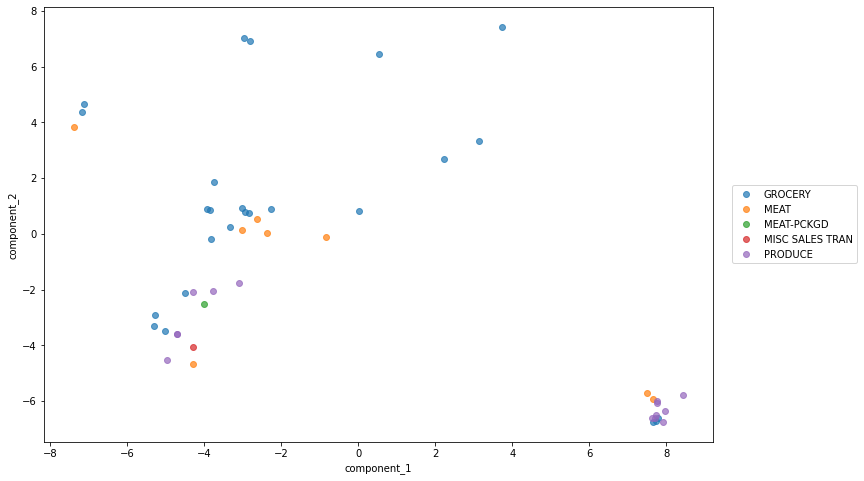

In [32]:
display_components_in_2D_space(item_emb_tsne[item_emb_tsne['item_id'].isin(similar_items)], 
                               labels='category')

Берем топ-5 популярных покупок юзера --> находим по 1 наиболее близкому товару СТМ для них --> рекомендуем

In [37]:
# your_code

popularity = data_train.groupby(['user_id', 'item_id'])['quantity'].count().reset_index()
popularity.sort_values('quantity', ascending=False, inplace=True)

popularity = popularity[popularity['item_id'] != 999999]

popularity = popularity.groupby('user_id').head(5)

popularity.sort_values(by=['user_id','quantity'], ascending=False, inplace=True)
popularity.head(10)

,user_id,item_id,quantity
665502,2500,1082185,21
665263,2500,859237,16
665587,2500,6534178,12
665479,2500,1065538,10
665473,2500,1058997,9
665106,2499,1070820,24
664829,2499,826249,10
665177,2499,5568378,8
665111,2499,1074405,7
665031,2499,999971,7


In [38]:
%%time


def get_rec_similar_items(model, x):
    recs = model.similar_items(itemid_to_id[x], N=2) # Подаем идшник
    top_rec = recs[1][0]
    return id_to_itemid[top_rec] # возвращаем ид похожего товара СТМ
    

popularity['similar_recommendation'] = popularity['item_id'].apply(lambda x: get_rec_similar_items(model, x))
popularity.head(3)

Wall time: 1.68 s


,user_id,item_id,quantity,similar_recommendation
665502,2500,1082185,21,999999
665263,2500,859237,16,1085604
665587,2500,6534178,12,999999


Тут на 999999 не обращать внимание, что-то не так сработало

In [39]:
recommendation_similar_items = popularity.groupby('user_id')['similar_recommendation'].unique().reset_index()
recommendation_similar_items.columns=['user_id', 'similar_recommendation']
recommendation_similar_items.head(2)

,user_id,similar_recommendation
0,1,"[824758, 999999, 840361, 5582712, 1098066]"
1,2,"[1133018, 1137346, 1106523, 5569845, 985999]"


In [40]:
result_predict = result.merge(recommendation_similar_items, on='user_id', how='inner')
result_predict.head(2)

,user_id,actual,bpr_bm25,als_bm25,similar_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1082185, 1127831, 854852, 878996, 961554]","[960732, 1082212, 999391, 885290, 1075074]","[824758, 999999, 840361, 5582712, 1098066]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[951590, 826249, 5568378, 883404, 1098066]","[1110244, 8090521, 951590, 885697, 5569230]","[1076875, 1092026, 960318, 1075979, 940766]"


In [41]:

from metrics import precision_at_k

# result.apply(lambda row: precision_at_k(row['similar_recommendation'], row['actual']), axis=1).mean()
result_predict.apply(lambda row: precision_at_k(row['similar_recommendation'], row['actual']), axis=1).mean()

0.07396498118147603

### Кейс 2. Вашим друзьям нравится / Похожим пользователям нравится / ...

Пользователь --> похожих пользовтелей --> рекомендовать те товары, которые купили похожие юзеры

Возьмем конкретного пользователя

In [57]:
userid_to_id[15]

14

Находим по нему топ похожих пользователей

In [58]:
model.similar_users(userid_to_id[15], N=6)

[(14, 0.9999998),
 (990, 0.8169747),
 (140, 0.80332893),
 (1347, 0.7940964),
 (564, 0.79336894),
 (381, 0.7648783)]

Для каждого из похожих пользователей можем получить рекомендации из их собственных покупок, найдем к примеру по одному продукту и из этого и сделаем рекомендацию

In [59]:
%%time

own = ItemItemRecommender(K=1, num_threads=4) # K - кол-во билжайших соседей

own.fit(csr_matrix(user_item_matrix).T.tocsr(), 
          show_progress=True)

recs = model.recommend(userid=userid_to_id[15], 
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=False)

  0%|          | 0/5001 [00:00<?, ?it/s]

Wall time: 358 ms


In [60]:
get_recommendations(user=15, model=own, N=1)

[910439]

# Добавка к Content-based 

- по картинкам

- по текстам (описания товаров, комментарии, заголовки)

Получаем вектора по-любому контенту и дальше считаем KNN